2025/08/04 12:39:43 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: OriginalHHO(epoch=15, pop_size=20)
2025/08/04 12:41:41 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >>>Problem: P, Epoch: 1, Current best: -0.6819062693290923, Global best: -0.6819062693290923, Runtime: 31.51146 seconds
2025/08/04 12:42:03 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >>>Problem: P, Epoch: 2, Current best: -0.7101609953274823, Global best: -0.7101609953274823, Runtime: 22.00551 seconds
2025/08/04 12:42:31 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >>>Problem: P, Epoch: 3, Current best: -0.7101609953274823, Global best: -0.7101609953274823, Runtime: 28.04517 seconds
2025/08/04 12:42:59 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >>>Problem: P, Epoch: 4, Current best: -0.7101609953274823, Global best: -0.7101609953274823, Runtime: 27.87871 seconds
2025/08/04 12:43:19 AM, INFO, mealpy.swarm_based.HHO.OriginalHHO: >>>Problem: P, Epoch: 5, Current best: -0.7101609953274823, Global best: -0.7101609953274


[HHO] Best hidden layer sizes found:
  Layer 1 size: 4
  Layer 2 size: 12
  Layer 3 size: 16

[HHO] Performance on Test Set:
  R² Score: 0.61761
  Mean Squared Error (MSE): 100.39322
  Mean Absolute Error (MAE): 5.88238

[HHO] Total Runtime: 451.12 seconds
Convergence history saved to 'hho_convergence_run9.csv'


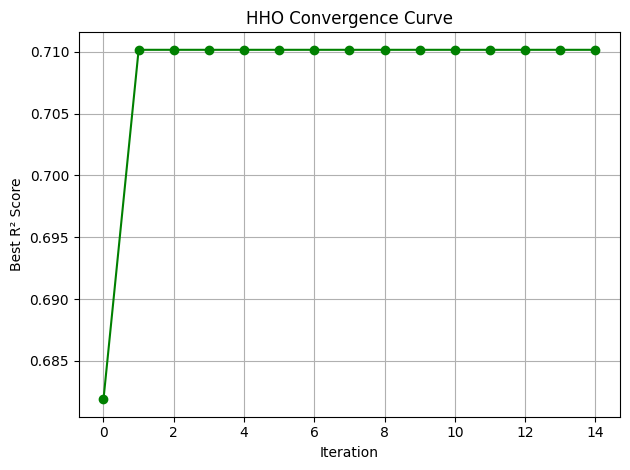

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning
from mealpy import HHO
from mealpy.utils.space import IntegerVar
from mealpy.utils.problem import Problem

# === Suppress convergence warnings ===
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# === Load dataset ===
csv_file = 'processed_heat_stress_data_UNSCALED.csv'
input_cols = list(range(2, 5)) + list(range(6, 12))
target_col = 12
data = pd.read_csv(csv_file).dropna()
X = data.iloc[:, input_cols].values
y = data.iloc[:, target_col].values

# === Train-test split (70% train, 30% test) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# === Normalize using only training data ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Objective function ===
def nn_objective(solution):
    l1 = int(np.clip(np.round(solution[0]), 5, 100))
    l2 = int(np.clip(np.round(solution[1]), 5, 100))
    l3 = int(np.clip(np.round(solution[2]), 5, 100))

    try:
        model = MLPRegressor(
            hidden_layer_sizes=(l1, l2, l3),
            activation='tanh',
            solver='lbfgs',
            max_iter=1000,
            random_state=42
        )
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
    except Exception:
        r2 = -np.inf

    return [-r2]  # MEALPY minimizes

# === HHO Settings ===
problem = Problem(
    obj_func=nn_objective,
    bounds=[
        IntegerVar(5, 100),
        IntegerVar(5, 100),
        IntegerVar(5, 100)
    ],
    minmax="min",
    log_to_console=True
)

model = HHO.OriginalHHO(
    epoch=15,
    pop_size=20,
    seed=8
)

# === Start timing ===
start_time = time.time()

# === Run HHO optimization ===
agent = model.solve(problem=problem)
best_solution = agent.solution
best_fitness = agent.target
hho_history = model.history

# === End timing ===
end_time = time.time()
elapsed_time = end_time - start_time

# === Extract best hyperparameters ===
best_l1 = int(np.round(best_solution[0]))
best_l2 = int(np.round(best_solution[1]))
best_l3 = int(np.round(best_solution[2]))

# === Retrain final model ===
final_model = MLPRegressor(
    hidden_layer_sizes=(best_l1, best_l2, best_l3),
    activation='tanh',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_scaled, y_train)
final_preds = final_model.predict(X_test_scaled)

final_r2 = r2_score(y_test, final_preds)
final_mse = mean_squared_error(y_test, final_preds)
final_mae = mean_absolute_error(y_test, final_preds)

# === Output ===
print("\n[HHO] Best hidden layer sizes found:")
print(f"  Layer 1 size: {best_l1}")
print(f"  Layer 2 size: {best_l2}")
print(f"  Layer 3 size: {best_l3}")
print(f"\n[HHO] Performance on Test Set:")
print(f"  R² Score: {final_r2:.5f}")
print(f"  Mean Squared Error (MSE): {final_mse:.5f}")
print(f"  Mean Absolute Error (MAE): {final_mae:.5f}")
print(f"\n[HHO] Total Runtime: {elapsed_time:.2f} seconds")

# === Convergence Curve from Mealpy ===
loss_train = hho_history.list_global_best_fit  # This is [-R²]
r2_history = [-loss for loss in loss_train]    # Flip sign to get R²

# === Save convergence curve to CSV ===
df_hho_hist = pd.DataFrame({
    'Iteration': range(1, len(r2_history) + 1),
    'Best_R2': r2_history
})
df_hho_hist.to_csv('hho_convergence_run10.csv', index=False)
print("Convergence history saved to 'hho_convergence_run10.csv'")

# === Plot it ===
plt.plot(r2_history, marker='o', linestyle='-', color='green')
plt.title("HHO Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Best R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()